# Datathon AI X DATA: Vision Pillar (Spring 2025)

# Sports Video Game Image Classification

This notebook implements a deep learning model to classify images of sports video games into five categories: Basketball, Volleyball, Tennis, Soccer, and American Football. We'll use a pre-trained ResNet101V2 model and fine-tune it on the Sports10 dataset.

## 1. Importing Libraries

Here, we import the necessary libraries for data manipulation, visualization, and building our deep learning model.

In [1]:
# --- Importing Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model  
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet101V2  
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image  
import os

In [2]:
# Configuration for plots
plt.rcParams['figure.figsize'] = [10, 6]  # Default figure size
plt.rcParams['figure.dpi'] = 100  #  Dots per inch (resolution) 
sns.set_theme(style="whitegrid")  

## 2. Configuration and Hyperparameters

We define key parameters and settings for our project, such as file paths, image dimensions, batch size, learning rate, and the number of epochs.

In [3]:
# --- Configuration ---
data_file_test = '/kaggle/input/vision/test.csv'
data_file_train = '/kaggle/input/vision/train.csv'
data_file_images = '/kaggle/input/vision/images'
NUM_CLASSES = 5
BATCH_SIZE = 32
IMG_HEIGHT, IMG_WIDTH = 224, 224
LEARNING_RATE = 0.001
NUM_EPOCHS = 20

## 3. Loading and Exploring the Dataset

We load the dataset into test_df and train_df. Then explore the data and split the training data to a training and validation set

In [4]:
# --- Load Data and Create Validation Set ---

## Load the training dataset from 'train.csv' into a Pandas DataFrame
test_df = pd.read_csv(data_file_test)

# Load the testing dataset from 'test.csv' into a Pandas DataFrame
train_df = pd.read_csv(data_file_train)

# Display a random sample of 10 rows from the training dataset
train_df.sample(10)

,filename,class,id
479,images/480.jpg,Soccer,480
936,images/937.jpg,Volleyball,937
789,images/790.jpg,Tennis,790
601,images/602.jpg,Tennis,602
500,images/501.jpg,Soccer,501
856,images/857.jpg,Volleyball,857
779,images/780.jpg,Tennis,780
49,images/50.jpg,AmericanFootball,50
595,images/596.jpg,Soccer,596
169,images/170.jpg,AmericanFootball,170


In [5]:
train_df.columns

Index(['filename', 'class', 'id'], dtype='object')

In [6]:
test_df.columns 

Index(['filename', 'id'], dtype='object')

In [7]:
# Split the training data into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['class'])

In [8]:
# Count the occurrences of each class in the 'class' column of the training dataset
class_counts = train_df['class'].value_counts()
print("Class Counts:\n", class_counts)

Class Counts:
 class
Basketball          160
Tennis              160
Volleyball          160
Soccer              160
AmericanFootball    160
Name: count, dtype: int64


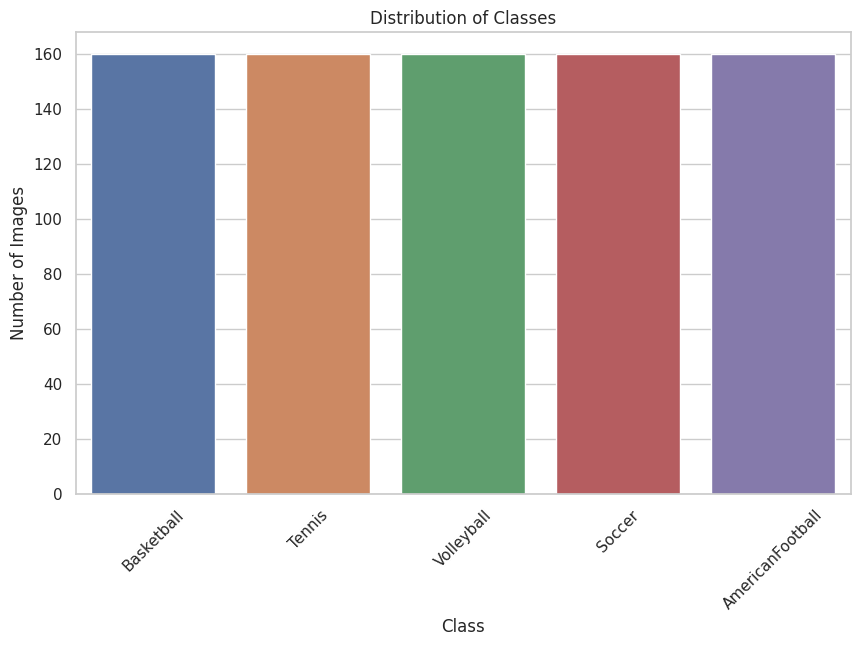

In [9]:
# Create a bar plot using Seaborn to visualize class distribution
sns.barplot(x=class_counts.index, y=class_counts.values)

plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


Displaying images for class: AmericanFootball


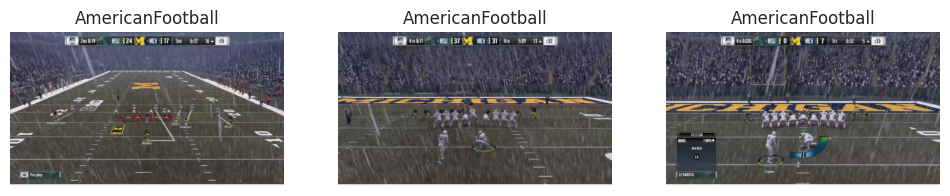

Displaying images for class: Basketball


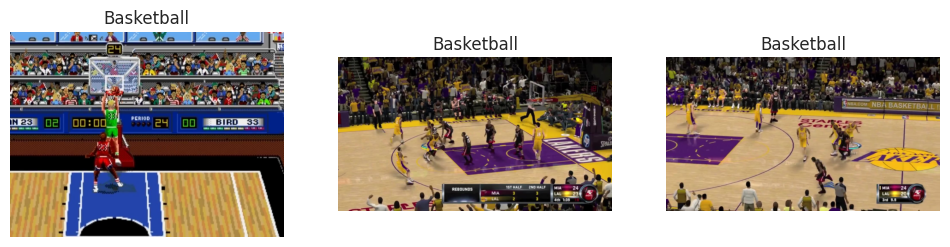

Displaying images for class: Soccer


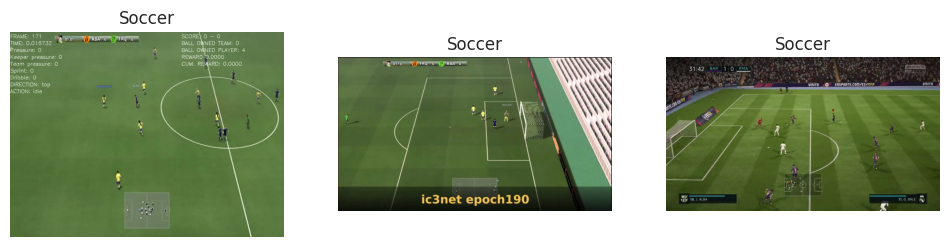

Displaying images for class: Tennis


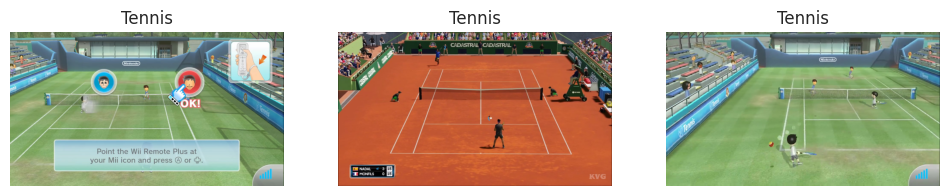

Displaying images for class: Volleyball


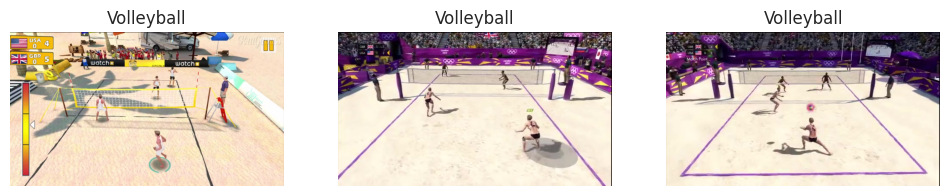

In [10]:
# This code selects 3 random images per class from the dataset and displays them using matplotlib. 
# It helps in visually inspecting dataset quality and variety.

# Get unique class names
class_names = sorted(train_df['class'].unique())

# Display a few images from each class
for class_name in class_names:
    print(f"Displaying images for class: {class_name}")
    class_images = train_df[train_df['class'] == class_name]['filename'].sample(3) #get 3 first images of each class

    plt.figure(figsize=(12, 4))
    for i, image_path in enumerate(class_images):
        img = Image.open(os.path.join(data_file_images, image_path))
        plt.subplot(1, 3, i + 1)  # 1 row, 3 columns, index i+1
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')  
    plt.show()

## 4. ImageDataGenerator
 A class that we define how to preprocess and augment the images. This helps prevents overfitting by artificially increasing dataset diversity. Also, improves generalization so the model learns robust features rather than memorizing training data.

In [11]:
# -- Data augmentation --
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalizes pixel value, [0, 1]
    rotation_range=20,  # Randomly rotates image
    width_shift_range=0.2,  # Randomly shift images
    height_shift_range=0.2, # Randomly shift images
    shear_range=0.2, # Disorts the image
    zoom_range=0.2, # Randomly zoom
    horizontal_flip=True,  # Randomly flip images
    fill_mode='nearest' # Fill in newly created pixels 
)

# Don't want to change the validation and test set images
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

## 5. Create Generators
These generators act as iterators and also produce data in batches in which allows training on batches

In [12]:
BATCH_SIZE = 4  # Small batch size for easier visualization

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=data_file_images,
    x_col='filename',
    y_col='class',
    target_size=(224, 224), 
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True 
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_df,  
    directory=data_file_images,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=data_file_images,
    x_col='filename',
    y_col=None,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

Found 800 validated image filenames belonging to 5 classes.
Found 200 validated image filenames belonging to 5 classes.
Found 129 validated image filenames.


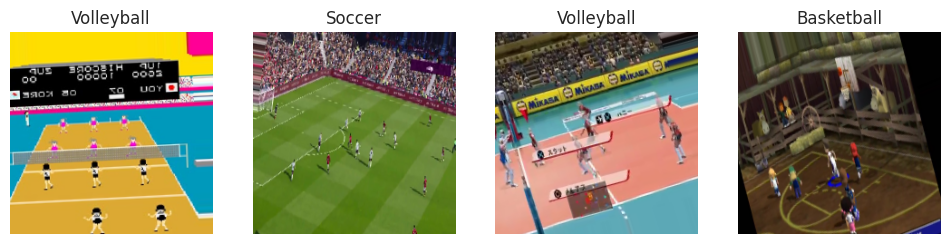

In [13]:
# Get a single batch of images and labels from the generator
images, labels = next(train_generator)

# Get class names from the generator
class_names = list(train_generator.class_indices.keys())

# Display the images in the batch
plt.figure(figsize=(12, 8))
for i in range(BATCH_SIZE):  # Iterate through the batch
    plt.subplot(1, BATCH_SIZE, i + 1)  # Create subplots
    plt.imshow(images[i])
    label_index = labels[i].argmax() #Find the index of the max value of the one-hot label
    plt.title(class_names[label_index]) 
    plt.axis('off')
plt.show()

## 6. Model Definition - ResNet101V2
Implementing the model with additional layers

In [14]:
# --- Model Definition (ResNet101V2) ---

# Load pre-trained ResNet101V2
base_model = ResNet101V2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    pooling='avg'  
)

# Add custom layers
x = base_model.output
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x) 

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers initially
# To prevent the large pre-trained weights from being drastically changed during the early stages of training.
for layer in base_model.layers:
    layer.trainable = False

171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## 7. Loss Function and Optimizer
Compiles the model, specifying the optimizer (Adam), the loss function (categorical_crossentropy for multi-class classification), and the metric to track (accuracy).

In [15]:
# --- Loss Function and Optimizer ---
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 8. Training Loop
This trains the model using the train_generator. steps_per_epoch is calculated to use all training samples in each epoch

In [16]:
# --- Training Loop ---
BATCH_SIZE = 32
history = model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    validation_data=validation_generator,  
    validation_steps=validation_generator.n // BATCH_SIZE
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 290ms/step - accuracy: 0.4196 - loss: 3.2525 - val_accuracy: 0.6667 - val_loss: 1.3337
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.6528 - loss: 1.4304 - val_accuracy: 0.9583 - val_loss: 0.3047
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8184 - loss: 0.5705 - val_accuracy: 0.9583 - val_loss: 0.0978
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9098 - loss: 0.2237 - val_accuracy: 0.9583 - val_loss: 0.0996
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.8954 - loss: 0.2547 - val_accuracy: 0.9583 - val_loss: 0.1261
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9527 - loss: 0.2379 - val_accuracy: 0.9583 - val_loss: 0.1612
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8659 - loss: 0.3267 - val_accuracy: 0.7917 - val_loss: 0.7310
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9303 - loss: 0.2165 - val_accuracy: 0.8750 - val_loss: 

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9146 - loss: 0.2658 - val_accuracy: 0.9583 - val_loss: 0.0620
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8944 - loss: 0.2141 - val_accuracy: 0.7083 - val_loss: 0.6916
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9409 - loss: 0.1948 - val_accuracy: 0.9167 - val_loss: 0.1876
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9630 - loss: 0.1163 - val_accuracy: 0.9583 - val_loss: 0.1512
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9360 - loss: 0.1491 - val_accuracy: 1.0000 - val_loss: 0.0364
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9641 - loss: 0.1641 - val_accuracy: 0.9583 - val_loss: 0.0782
Epoch 16/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9320 - loss: 0.2214 - val_accuracy: 0.9167 - val_loss: 0.1388
Epoch 17/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9045 - loss: 0.2221 - val_accuracy: 0.8750 - val_l

## 9. Fine-tuning
After the initial training, some layers of the base model are unfrozen, and the model is recompiled with a lower learning rate. It allows the pre-trained weights to be adjusted slightly to better fit your specific dataset, often leading to improved performance.

In [17]:
# --- Fine-tuning ---
for layer in base_model.layers[int(len(base_model.layers) * 0.75):]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE / 10),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=int(NUM_EPOCHS / 2),
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    validation_data=validation_generator,  
    validation_steps=validation_generator.n // BATCH_SIZE
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 275ms/step - accuracy: 0.6510 - loss: 1.5653 - val_accuracy: 0.7917 - val_loss: 0.3776
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8552 - loss: 0.3297 - val_accuracy: 0.9167 - val_loss: 0.2879
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9296 - loss: 0.2855 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8945 - loss: 0.2904 - val_accuracy: 0.9583 - val_loss: 0.4430
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8831 - loss: 0.3031 - val_accuracy: 0.9583 - val_loss: 0.1603
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8415 - loss: 0.3245 - val_accuracy: 0.9583 - val_loss: 0.1220
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9354 - loss: 0.2499 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9434 - loss: 0.2395 - val_accuracy: 0.9583 -

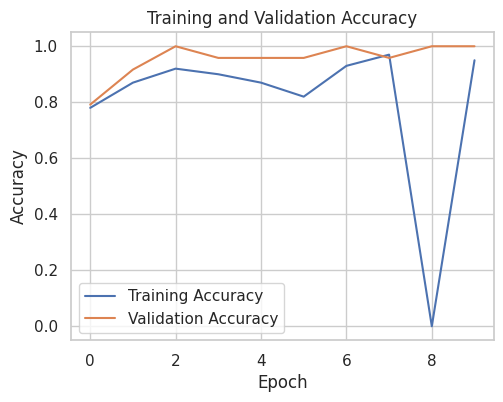

In [18]:
plt.figure(figsize=(12, 4))  # Adjust figure size for better readability

plt.subplot(1, 2, 1)  # Create a subplot (1 row, 2 columns, first plot)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

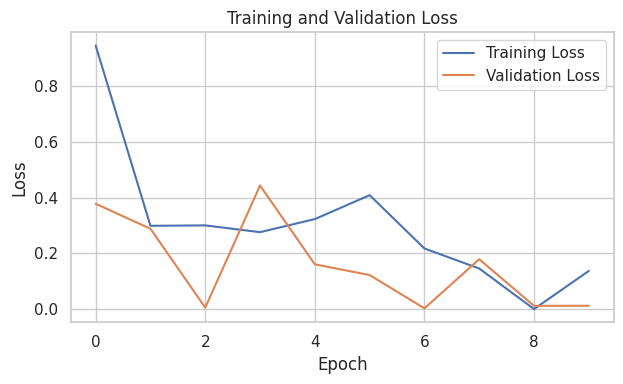

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 2)  # Create the second subplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust subplot parameters for a tight layout.
plt.show()

In [20]:
predictions = model.predict(test_generator, steps=test_generator.n // BATCH_SIZE + 1)
predicted_classes = np.argmax(predictions, axis=1)

class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
predicted_labels = [idx_to_class[i] for i in predicted_classes]

submission_df = pd.DataFrame({
    'id': test_df['id'][:len(predicted_labels)],
    'class': predicted_labels
})

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step


In [21]:
submission_df.head()

,id,class
0,1001,Volleyball
1,1002,Soccer
2,1003,Tennis
3,1004,Volleyball
4,1005,Volleyball


In [22]:
# submission_df.to_csv('submission.csv', index=False)
# print("Submission file 'submission.csv' created.")